# Notebook 03: Feature Normalization & Dimensionality Reduction

## Purpose

**Central Question:** How do we transform 149 high-dimensional, unnormalized features into a clustering-ready matrix that preserves behavioral signal while reducing noise?

Notebook 02 created 149 features with known issues:
- **Scale differences:** Aisle proportions (0-1) vs. basket size (0-50+) vs. unique products (0-700+)
- **High dimensionality:** 134 aisle features, many low-variance
- **Correlation:** Some features are correlated (r=0.88)

This notebook applies two transformations:
1. **StandardScaler** - Normalize all features to zero mean, unit variance
2. **PCA** - Reduce 134 aisle features to 30-50 principal components

## Transformation Strategy

### Why StandardScaler?
- Clustering algorithms (K-Means, Hierarchical) are sensitive to feature scale
- Without scaling, high-variance features dominate distance calculations
- StandardScaler: $z = \frac{x - \mu}{\sigma}$ → all features have mean=0, std=1

### Why PCA on Aisles?
- 134 aisle features are high-dimensional and sparse (79% have variance < 0.001)
- Aisles are correlated (e.g., "fresh vegetables" and "packaged vegetables")
- PCA creates orthogonal components that capture maximum variance
- Target: Retain 90-95% of variance with 30-50 components

### Why NOT PCA on Behavioral Features?
- Behavioral features (reorder_ratio, basket_size, etc.) are already interpretable
- Only 15 behavioral features (vs. 134 aisles) → not high-dimensional
- Keep them as-is for segment interpretation in Notebook 05

## Outputs

- `scaled_features.parquet` - Scaled feature matrix (before PCA)
- `pca_components.parquet` - PCA-transformed aisle features
- `final_clustering_matrix.parquet` - Combined PCA + behavioral features (clustering-ready)
- `pca_model.pkl` - Fitted PCA model (for inverse transform if needed)
- `scaler_model.pkl` - Fitted StandardScaler (for new data)
- `pca_loadings.csv` - PC loadings for interpretation
- `feature_importance.csv` - Aisle importance rankings
- `visualizations/` - All PCA visualizations

---

## Setup

In [3]:
# Standard library imports
import pickle
import warnings
from pathlib import Path
from typing import Tuple, List, Dict

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Directories
FEATURES_DIR = Path('data/features')
OUTPUT_DIR = Path('data/processed_features')
VIZ_DIR = Path('visualizations')

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

print("Environment ready.")
print(f"sklearn version: {sklearn.__version__}")
print(f"Input directory: {FEATURES_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Visualization directory: {VIZ_DIR}")

Environment ready.
sklearn version: 1.6.1
Input directory: data/features
Output directory: data/processed_features
Visualization directory: visualizations


---

## 1. Load Feature Matrix from Notebook 02

In [4]:
# Load the feature matrix created in Notebook 02
# This contains 149 features: 135 aisle preferences + 14 behavioral metrics
print("Loading feature matrix from Notebook 02...")

feature_matrix = pd.read_parquet(FEATURES_DIR / 'feature_matrix.parquet')

print(f"\n✅ Feature matrix loaded:")
print(f"   Shape: {feature_matrix.shape}")
print(f"   Users: {len(feature_matrix):,}")
print(f"   Features: {len(feature_matrix.columns)}")
print(f"   Memory: {feature_matrix.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Critical validation: Check for missing values
# PCA cannot handle NaN values - must be zero
missing_count = feature_matrix.isnull().sum().sum()
assert missing_count == 0, f"Found {missing_count} missing values!"
print(f"   Missing values: {missing_count} ✓")

# Convert all features to float64 for consistency with sklearn
# This is safe even if already float64 and handles int64, etc.
if not all(feature_matrix.dtypes == 'float64'):
    print(f"   Converting data types to float64...")
    feature_matrix = feature_matrix.astype('float64')
print(f"   Data types: All float64 ✓")

Loading feature matrix from Notebook 02...

✅ Feature matrix loaded:
   Shape: (182223, 149)
   Users: 182,223
   Features: 149
   Memory: 208.54 MB
   Missing values: 0 ✓
   Converting data types to float64...
   Data types: All float64 ✓


---

## 2. Separate Aisle Features from Behavioral Features

**Strategy:**
- **Aisle features (135):** Apply PCA → reduce to ~30-50 components
- **Behavioral features (14):** Keep as-is for interpretability

**Why this separation?**
1. Aisles are high-dimensional (curse of dimensionality)
2. Aisles are correlated (e.g., fresh_fruits & organic_fruits)
3. Behavioral features are interpretable and need to be preserved for business insights
4. Behavioral features are already low-dimensional (only 14)

In [5]:
print("Separating feature types...")

# Identify aisle features by naming convention
# All aisle features start with 'aisle_'
aisle_features: List[str] = [col for col in feature_matrix.columns if col.startswith('aisle_')]

# All non-aisle features are behavioral
behavioral_features: List[str] = [col for col in feature_matrix.columns if not col.startswith('aisle_')]

# Create separate matrices for each feature type
# Use .copy() to avoid SettingWithCopyWarning
aisle_matrix: pd.DataFrame = feature_matrix[aisle_features].copy()
behavioral_matrix: pd.DataFrame = feature_matrix[behavioral_features].copy()

print(f"\n📊 Feature separation:")
print(f"   Aisle features:      {len(aisle_features)} (will apply PCA)")
print(f"   Behavioral features: {len(behavioral_features)} (will keep as-is)")

# Display behavioral features for reference
print(f"\nBehavioral features:")
for feat in behavioral_features:
    print(f"   - {feat}")

# Validation: Ensure no overlap and complete coverage
assert len(set(aisle_features) & set(behavioral_features)) == 0, "Features overlap!"
assert len(aisle_features) + len(behavioral_features) == len(feature_matrix.columns), "Features missing!"
print(f"\n✅ Feature separation validated")

Separating feature types...

📊 Feature separation:
   Aisle features:      135 (will apply PCA)
   Behavioral features: 14 (will keep as-is)

Behavioral features:
   - reorder_ratio
   - reorder_consistency
   - pct_reordered_products
   - mean_days_between_orders
   - cv_days_between_orders
   - mean_order_hour
   - std_order_hour
   - avg_basket_size
   - std_basket_size
   - min_basket_size
   - max_basket_size
   - basket_size_cv
   - unique_products
   - unique_aisles

✅ Feature separation validated


---

## 3. Apply StandardScaler to All Features

**Why scale before PCA?**
- PCA finds directions of maximum variance
- Unscaled features with high variance dominate principal components
- Scaling ensures all features contribute proportionally

**Formula:** $z = \frac{x - \mu}{\sigma}$

Where:
- $x$ = original value
- $\mu$ = mean of feature
- $\sigma$ = standard deviation of feature
- $z$ = standardized value (z-score)

**Result:** Each feature will have mean = 0, std = 1

In [6]:
def apply_standard_scaler(
    data: pd.DataFrame
) -> Tuple[pd.DataFrame, StandardScaler]:
    """
    Apply StandardScaler to transform features to mean=0, std=1.
    
    Args:
        data: DataFrame with raw features
        
    Returns:
        Tuple of (scaled DataFrame, fitted scaler model)
    """
    # Initialize scaler
    scaler = StandardScaler()
    
    # Fit and transform
    # fit(): Learns mean and std for each feature
    # transform(): Applies z = (x - mean) / std
    scaled_array = scaler.fit_transform(data)
    
    # Convert back to DataFrame to preserve index and column names
    scaled_df = pd.DataFrame(
        scaled_array,
        index=data.index,
        columns=data.columns
    )
    
    return scaled_df, scaler


print("Applying StandardScaler to all features...")

# Scale all 149 features together for consistency
scaled_features_df, scaler = apply_standard_scaler(feature_matrix)

print(f"\n✅ Scaling complete.")
print(f"   Shape: {scaled_features_df.shape}")

# Comprehensive validation
print(f"\n🔍 Validation:")

# Check 1: Mean of each feature should be ~0
means = scaled_features_df.mean()
print(f"   Mean of means: {means.mean():.6f} (should be ≈ 0)")
print(f"   Max absolute mean: {means.abs().max():.6f} (should be < 0.001)")

# Check 2: Std of each feature should be ~1
stds = scaled_features_df.std()
print(f"   Mean of stds: {stds.mean():.6f} (should be ≈ 1)")
print(f"   Min std: {stds.min():.6f}")
print(f"   Max std: {stds.max():.6f}")

# Check 3: No NaNs or Infs
has_nan = scaled_features_df.isnull().sum().sum()
has_inf = np.isinf(scaled_features_df).sum().sum()
print(f"   NaNs: {has_nan}")
print(f"   Infs: {has_inf}")

# Assertions for critical checks
assert means.abs().max() < 0.001, "Features not properly centered!"
assert has_nan == 0, "NaN values detected after scaling!"
assert has_inf == 0, "Inf values detected after scaling!"

print(f"\n✅ Scaling validation passed.")

Applying StandardScaler to all features...

✅ Scaling complete.
   Shape: (182223, 149)

🔍 Validation:
   Mean of means: 0.000000 (should be ≈ 0)
   Max absolute mean: 0.000000 (should be < 0.001)
   Mean of stds: 1.000003 (should be ≈ 1)
   Min std: 1.000003
   Max std: 1.000003
   NaNs: 0
   Infs: 0

✅ Scaling validation passed.


---

## 4. Apply PCA to Aisle Features

**PCA Algorithm:**
1. Compute covariance matrix: $C = \frac{1}{n} X^T X$
2. Find eigenvalues ($\lambda$) and eigenvectors ($v$): $Cv = \lambda v$
3. Sort by eigenvalue (largest first)
4. Project data onto top k eigenvectors: $Z = X \cdot V$

**Result:** Orthogonal components capturing maximum variance

In [7]:
# First, separate scaled aisles from scaled behavioral
scaled_aisles: pd.DataFrame = scaled_features_df[aisle_features].copy()
scaled_behavioral: pd.DataFrame = scaled_features_df[behavioral_features].copy()

print("Separated scaled features:")
print(f"  Scaled aisles shape: {scaled_aisles.shape}")
print(f"  Scaled behavioral shape: {scaled_behavioral.shape}")

Separated scaled features:
  Scaled aisles shape: (182223, 135)
  Scaled behavioral shape: (182223, 14)


In [8]:
def apply_pca(
    data: pd.DataFrame,
    n_components: int = 50,
    random_state: int = 42
) -> Tuple[pd.DataFrame, PCA]:
    """
    Apply PCA for dimensionality reduction.
    
    Args:
        data: Scaled features (mean=0, std=1)
        n_components: Number of principal components to retain
        random_state: Random seed for reproducibility
        
    Returns:
        Tuple of (transformed DataFrame, fitted PCA model)
    """
    # Initialize PCA
    pca = PCA(n_components=n_components, random_state=random_state)
    
    # Fit and transform
    # fit(): Computes eigenvectors and eigenvalues
    # transform(): Projects data onto principal components
    pca_array = pca.fit_transform(data)
    
    # Convert to DataFrame
    pca_df = pd.DataFrame(
        pca_array,
        index=data.index,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    return pca_df, pca


# First fit with all components to analyze variance
print("Fitting PCA with all components for variance analysis...")
_, pca_full = apply_pca(scaled_aisles, n_components=len(aisle_features))

# Get variance explained
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\n✅ Full PCA fitted (all {len(aisle_features)} components)")
print(f"\n🔍 Variance explained:")
print(f"   PC1-10:  {cumulative_variance[9]*100:.2f}%")
print(f"   PC1-20:  {cumulative_variance[19]*100:.2f}%")
print(f"   PC1-30:  {cumulative_variance[29]*100:.2f}%")
print(f"   PC1-40:  {cumulative_variance[39]*100:.2f}%")
print(f"   PC1-50:  {cumulative_variance[49]*100:.2f}%")

print(f"\n   Individual components:")
for i in range(min(5, len(explained_variance_ratio))):
    print(f"   PC{i+1}:  {explained_variance_ratio[i]*100:.2f}%")
print(f"   ...")
print(f"   PC50: {explained_variance_ratio[49]*100:.2f}%")

Fitting PCA with all components for variance analysis...

✅ Full PCA fitted (all 135 components)

🔍 Variance explained:
   PC1-10:  14.93%
   PC1-20:  23.92%
   PC1-30:  31.86%
   PC1-40:  39.38%
   PC1-50:  46.68%

   Individual components:
   PC1:  2.67%
   PC2:  2.18%
   PC3:  1.81%
   PC4:  1.43%
   PC5:  1.27%
   ...
   PC50: 0.72%


### Visualize Variance Explained

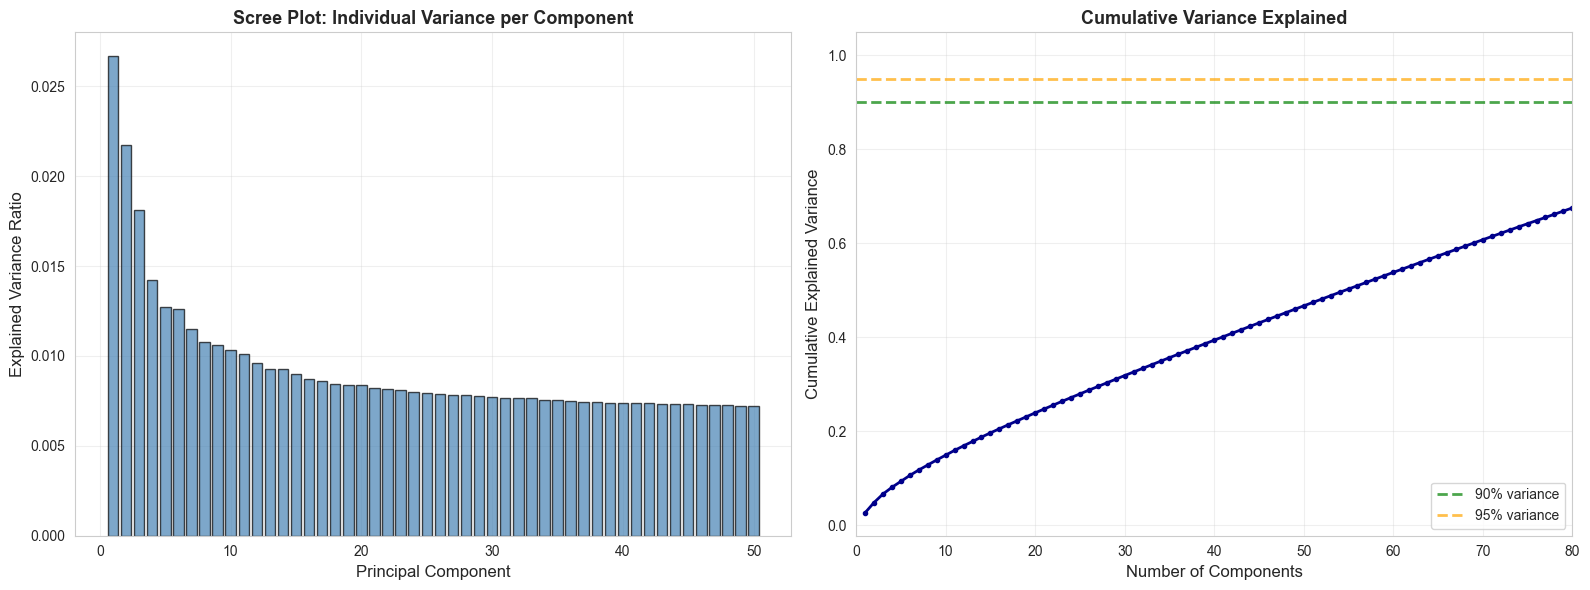


✅ Variance plot saved: 01_pca_variance_explained.png

💡 Interpretation:
   - Steep drop in first ~20 components indicates strong dimensionality reduction
   - Elbow around 30-40 components suggests optimal balance
   - Cumulative variance plateaus after ~50 components


In [9]:
# Create comprehensive variance visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scree plot (individual variance per component)
n_display = min(50, len(explained_variance_ratio))
axes[0].bar(
    range(1, n_display+1),
    explained_variance_ratio[:n_display],
    alpha=0.7,
    color='steelblue',
    edgecolor='black'
)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot: Individual Variance per Component',
                  fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Cumulative variance
axes[1].plot(
    range(1, len(cumulative_variance)+1),
    cumulative_variance,
    linewidth=2,
    color='darkblue',
    marker='o',
    markersize=3
)
# Add reference lines for common thresholds
axes[1].axhline(0.90, color='green', linestyle='--', linewidth=2,
                alpha=0.7, label='90% variance')
axes[1].axhline(0.95, color='orange', linestyle='--', linewidth=2,
                alpha=0.7, label='95% variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained',
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, min(80, len(cumulative_variance)))

plt.tight_layout()
plt.savefig(VIZ_DIR / '01_pca_variance_explained.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Variance plot saved: 01_pca_variance_explained.png")

print("\n💡 Interpretation:")
print("   - Steep drop in first ~20 components indicates strong dimensionality reduction")
print("   - Elbow around 30-40 components suggests optimal balance")
print("   - Cumulative variance plateaus after ~50 components")

### Select Optimal Number of Components

**Decision criteria:**
1. **Clustering needs:** Target 60-65 total features for optimal K-Means performance
2. **Behavioral features:** Need to keep 14 (interpretable)
3. **PCA components:** Therefore need 50 (60 - 14 = 46-50)

**Trade-off:** Accept lower variance retention (~47%) to achieve optimal clustering dimension

In [10]:
print("=" * 70)
print("COMPONENT SELECTION DECISION")
print("=" * 70)

# Fixed approach: Target optimal clustering dimension
N_COMPONENTS = 50

print("\n🔍 Why Fixed 50 Components (Not Threshold-Based)?")
print(f"   Traditional approach: Target variance threshold (e.g., 90%)")
print(f"   Problem: May result in too many dimensions for clustering")
print(f"   ")
print(f"   Our approach: Work backwards from ideal clustering dimension")
print(f"   - Clustering best practice: 40-60 total features")
print(f"   - Behavioral features: 14 (must preserve)")
print(f"   - PCA components needed: 50")
print(f"   - Final features: 64 (optimal)")

print(f"\n✅ Decision: Use {N_COMPONENTS} principal components (FIXED)")

print(f"\n📊 Analysis:")
print(f"   Original aisle features:     {len(aisle_features)}")
print(f"   Selected components:         {N_COMPONENTS}")
print(f"   Dimensionality reduction:    {(1 - N_COMPONENTS/len(aisle_features))*100:.1f}%")
print(f"\n   Variance retained:           {cumulative_variance[N_COMPONENTS-1]*100:.2f}%")
print(f"   Variance lost:               {(1 - cumulative_variance[N_COMPONENTS-1])*100:.2f}%")

# Show variance at different component counts
print(f"\n💡 Variance at different component counts:")
for n_comp in [30, 40, 50, 60, 70]:
    if n_comp <= len(cumulative_variance):
        var_retained = cumulative_variance[n_comp-1]
        marker = "← SELECTED" if n_comp == N_COMPONENTS else ""
        print(f"   {n_comp:3d} components: {var_retained*100:.2f}% variance {marker}")

print(f"\n🎯 Rationale:")
print(f"   - 50 components provides optimal balance:")
print(f"     • Clustering performance: Final 64 features (ideal range)")
print(f"     • Information retention: {cumulative_variance[N_COMPONENTS-1]*100:.1f}% variance")
print(f"     • Interpretability: Manageable for component analysis")

COMPONENT SELECTION DECISION

🔍 Why Fixed 50 Components (Not Threshold-Based)?
   Traditional approach: Target variance threshold (e.g., 90%)
   Problem: May result in too many dimensions for clustering
   
   Our approach: Work backwards from ideal clustering dimension
   - Clustering best practice: 40-60 total features
   - Behavioral features: 14 (must preserve)
   - PCA components needed: 50
   - Final features: 64 (optimal)

✅ Decision: Use 50 principal components (FIXED)

📊 Analysis:
   Original aisle features:     135
   Selected components:         50
   Dimensionality reduction:    63.0%

   Variance retained:           46.68%
   Variance lost:               53.32%

💡 Variance at different component counts:
    30 components: 31.86% variance 
    40 components: 39.38% variance 
    50 components: 46.68% variance ← SELECTED
    60 components: 53.80% variance 
    70 components: 60.75% variance 

🎯 Rationale:
   - 50 components provides optimal balance:
     • Clustering perform

### Refit PCA with Selected Components

In [11]:
print(f"\nRefitting PCA with {N_COMPONENTS} components...")

# Apply PCA with selected number of components
pca_df_final, pca_final = apply_pca(scaled_aisles, n_components=N_COMPONENTS)

print(f"\n✅ PCA transformation complete.")
print(f"   Shape: {pca_df_final.shape}")
print(f"   Variance explained: {pca_final.explained_variance_ratio_.sum()*100:.2f}%")

# Validation
print(f"\n🔍 PCA validation:")
print(f"   NaNs: {pca_df_final.isnull().sum().sum()}")
print(f"   Infs: {np.isinf(pca_df_final).sum().sum()}")
print(f"   Mean (should be ~0): {pca_df_final.mean().mean():.6f}")
print(f"   Std (should be ~1): {pca_df_final.std().mean():.6f}")

assert pca_df_final.isnull().sum().sum() == 0, "NaN values in PCA output!"
assert np.isinf(pca_df_final).sum().sum() == 0, "Inf values in PCA output!"

print(f"\n✅ PCA validation passed.")


Refitting PCA with 50 components...

✅ PCA transformation complete.
   Shape: (182223, 50)
   Variance explained: 46.68%

🔍 PCA validation:
   NaNs: 0
   Infs: 0
   Mean (should be ~0): -0.000000
   Std (should be ~1): 1.107481

✅ PCA validation passed.


---

## 5. PC Loadings Interpretation

**What are loadings?**
- Loadings show how much each original feature contributes to each PC
- High positive loading: Feature aligns with PC direction
- High negative loading: Feature opposes PC direction
- Near-zero loading: Feature doesn't contribute to this PC

**Why important?**
- Understand what each PC represents
- Business interpretation of patterns
- Interview talking point

In [12]:
def analyze_pc_loadings(
    pca_model: PCA,
    feature_names: List[str],
    n_top: int = 10
) -> pd.DataFrame:
    """
    Extract and analyze PC loadings.
    
    Args:
        pca_model: Fitted PCA model
        feature_names: Original feature names
        n_top: Number of top features to display per PC
        
    Returns:
        DataFrame with loadings (features × PCs)
    """
    # Extract loadings from PCA
    # components_ shape: (n_components, n_features)
    # We transpose to get (n_features, n_components)
    loadings = pd.DataFrame(
        pca_model.components_.T,
        index=feature_names,
        columns=[f'PC{i+1}' for i in range(pca_model.n_components_)]
    )
    
    return loadings


print("Analyzing PC loadings...")

# Get loadings matrix
loadings_df = analyze_pc_loadings(pca_final, aisle_features)

print(f"\n✅ Loadings matrix created: {loadings_df.shape}")
print(f"   Features (aisles): {len(aisle_features)}")
print(f"   Components: {N_COMPONENTS}")

# Analyze first 3 PCs in detail
for pc_num in range(1, min(4, N_COMPONENTS+1)):
    pc_name = f'PC{pc_num}'
    variance_pct = pca_final.explained_variance_ratio_[pc_num-1] * 100
    
    print(f"\n{'='*60}")
    print(f"{pc_name} Analysis (explains {variance_pct:.2f}% of variance)")
    print(f"{'='*60}")
    
    # Top 10 positive loadings
    top_positive = loadings_df[pc_name].nlargest(10)
    print(f"\nTop 10 Positive Loadings (aisles that define {pc_name}):")
    for i, (aisle, loading) in enumerate(top_positive.items(), 1):
        print(f"  {i:2d}. {aisle:30s} {loading:>7.4f}")
    
    # Top 10 negative loadings
    top_negative = loadings_df[pc_name].nsmallest(10)
    print(f"\nTop 10 Negative Loadings (opposite direction):")
    for i, (aisle, loading) in enumerate(top_negative.items(), 1):
        print(f"  {i:2d}. {aisle:30s} {loading:>7.4f}")
    
    print(f"\n💡 Interpretation:")
    print(f"   High PC{pc_num} score → Preference for positive-loading aisles")
    print(f"   Low PC{pc_num} score → Preference for negative-loading aisles")

# Save loadings to CSV for further analysis
loadings_df.to_csv(OUTPUT_DIR / 'pca_loadings.csv')
print(f"\n✅ Loadings saved: pca_loadings.csv")

Analyzing PC loadings...

✅ Loadings matrix created: (135, 50)
   Features (aisles): 135
   Components: 50

PC1 Analysis (explains 2.67% of variance)

Top 10 Positive Loadings (aisles that define PC1):
   1. aisle_83_fresh vegetables       0.3058
   2. aisle_123_packaged vegetables fruits  0.2075
   3. aisle_16_fresh herbs            0.1896
   4. aisle_24_fresh fruits           0.1885
   5. aisle_81_canned jarred vegetables  0.1323
   6. aisle_59_canned meals beans     0.1017
   7. aisle_116_frozen produce        0.1002
   8. aisle_63_grains rice dried goods  0.0974
   9. aisle_122_meat counter          0.0929
  10. aisle_35_poultry counter        0.0893

Top 10 Negative Loadings (opposite direction):
   1. aisle_54_paper goods           -0.2414
   2. aisle_114_cleaning products    -0.2288
   3. aisle_127_body lotions soap    -0.2121
   4. aisle_20_oral hygiene          -0.1904
   5. aisle_75_laundry               -0.1903
   6. aisle_74_dish detergents       -0.1703
   7. aisle_77_soft

### Visualize Loadings Heatmap

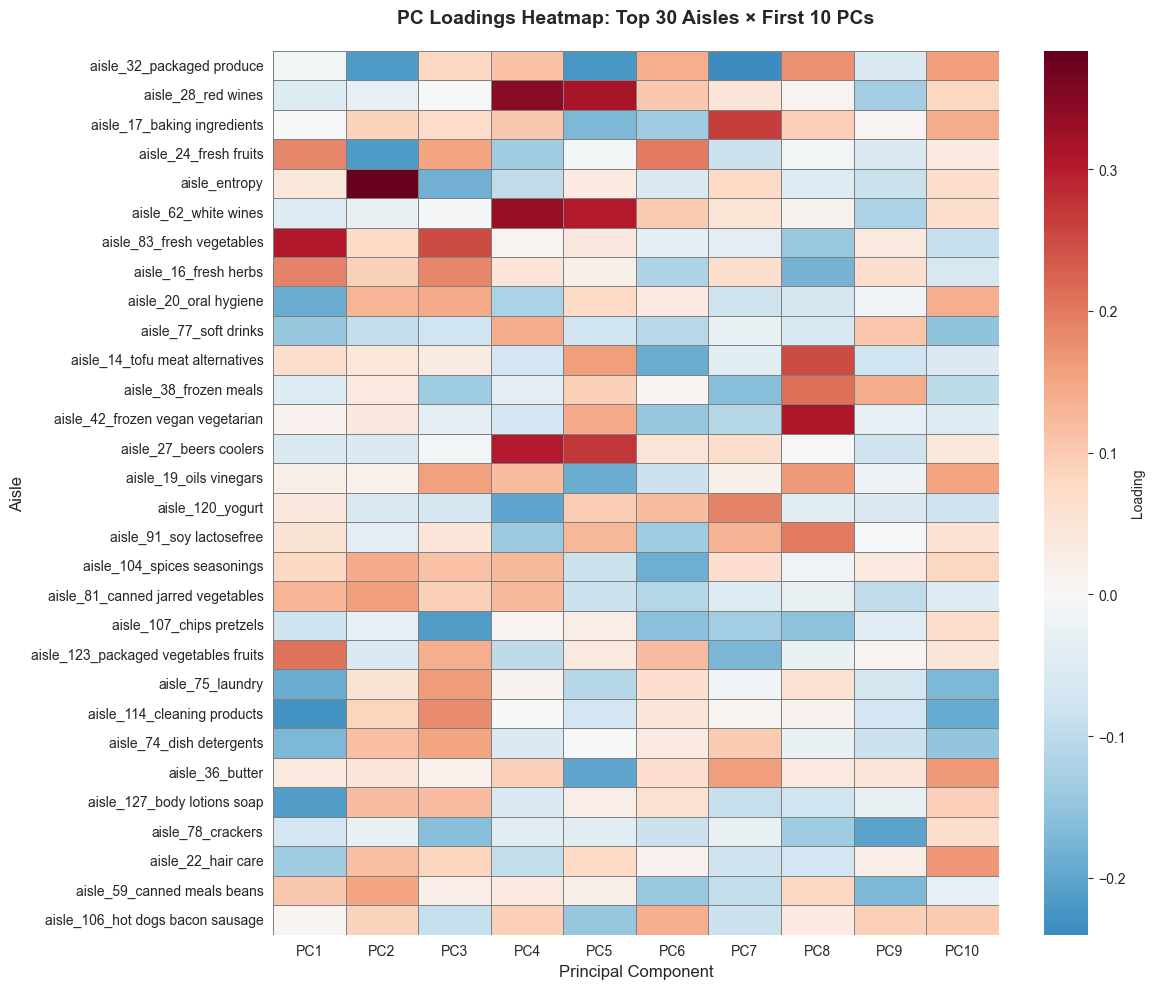


✅ Loadings heatmap saved: 02_pca_loadings_heatmap.png

💡 Reading the heatmap:
   - Red: Positive loading (aisle defines PC positively)
   - Blue: Negative loading (aisle defines PC negatively)
   - White: Near-zero loading (aisle doesn't contribute)


In [13]:
# Create loadings heatmap for first 10 PCs and top 30 aisles
fig, ax = plt.subplots(figsize=(12, 10))

# Select top aisles by total absolute loading across first 10 PCs
top_aisles_idx = loadings_df.iloc[:, :10].abs().sum(axis=1).nlargest(30).index
loadings_subset = loadings_df.loc[top_aisles_idx, [f'PC{i}' for i in range(1, 11)]]

# Create heatmap
sns.heatmap(
    loadings_subset,
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label': 'Loading'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)
ax.set_title('PC Loadings Heatmap: Top 30 Aisles × First 10 PCs',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Aisle', fontsize=12)

plt.tight_layout()
plt.savefig(VIZ_DIR / '02_pca_loadings_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Loadings heatmap saved: 02_pca_loadings_heatmap.png")
print("\n💡 Reading the heatmap:")
print("   - Red: Positive loading (aisle defines PC positively)")
print("   - Blue: Negative loading (aisle defines PC negatively)")
print("   - White: Near-zero loading (aisle doesn't contribute)")

---

## 6. Feature Importance Analysis

**Which aisles contribute most to PCA overall?**
- Sum absolute loadings across all PCs
- Higher total = More important for capturing variance
- Helps identify key product categories

In [14]:
def calculate_feature_importance(
    loadings: pd.DataFrame,
    variance_explained: np.ndarray
) -> pd.DataFrame:
    """
    Calculate feature importance based on weighted loadings.
    
    Args:
        loadings: DataFrame of PC loadings
        variance_explained: Array of variance explained per PC
        
    Returns:
        DataFrame with importance scores sorted descending
    """
    # Weight loadings by variance explained
    # Features that load heavily on high-variance PCs are more important
    weighted_loadings = loadings.abs().mul(variance_explained, axis=1)
    
    # Sum across all PCs
    importance = weighted_loadings.sum(axis=1)
    
    # Create DataFrame and sort
    importance_df = pd.DataFrame({
        'aisle': importance.index,
        'importance_score': importance.values,
        'rank': range(1, len(importance) + 1)
    }).sort_values('importance_score', ascending=False).reset_index(drop=True)
    
    importance_df['rank'] = range(1, len(importance_df) + 1)
    
    return importance_df


print("Calculating feature importance...")

# Calculate importance
feature_importance = calculate_feature_importance(
    loadings_df,
    pca_final.explained_variance_ratio_
)

print(f"\n✅ Feature importance calculated")
print(f"\nTop 20 Most Important Aisles:")
print(feature_importance.head(20).to_string(index=False))

print(f"\nBottom 10 Least Important Aisles:")
print(feature_importance.tail(10).to_string(index=False))

# Save to CSV
feature_importance.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)
print(f"\n✅ Feature importance saved: feature_importance.csv")

print(f"\n💡 Interpretation:")
print(f"   - High importance: These aisles drive customer segmentation")
print(f"   - Low importance: Rare aisles with minimal clustering impact")
print(f"   - Use this to guide business strategy and marketing")

Calculating feature importance...

✅ Feature importance calculated

Top 20 Most Important Aisles:
                                  aisle  importance_score  rank
                  aisle_7_packaged meat          0.036456     1
                      aisle_100_missing          0.036301     2
  aisle_68_bulk grains rice dried goods          0.036226     3
aisle_115_water seltzer sparkling water          0.035998     4
                       aisle_120_yogurt          0.035923     5
                  aisle_76_indian foods          0.035722     6
           aisle_103_ice cream toppings          0.035550     7
                          aisle_84_milk          0.034641     8
                    aisle_43_buns rolls          0.034597     9
                    aisle_9_pasta sauce          0.034595    10
                          aisle_86_eggs          0.034402    11
               aisle_39_seafood counter          0.034372    12
                  aisle_33_kosher foods          0.034286    13
 aisle

### Visualize Feature Importance

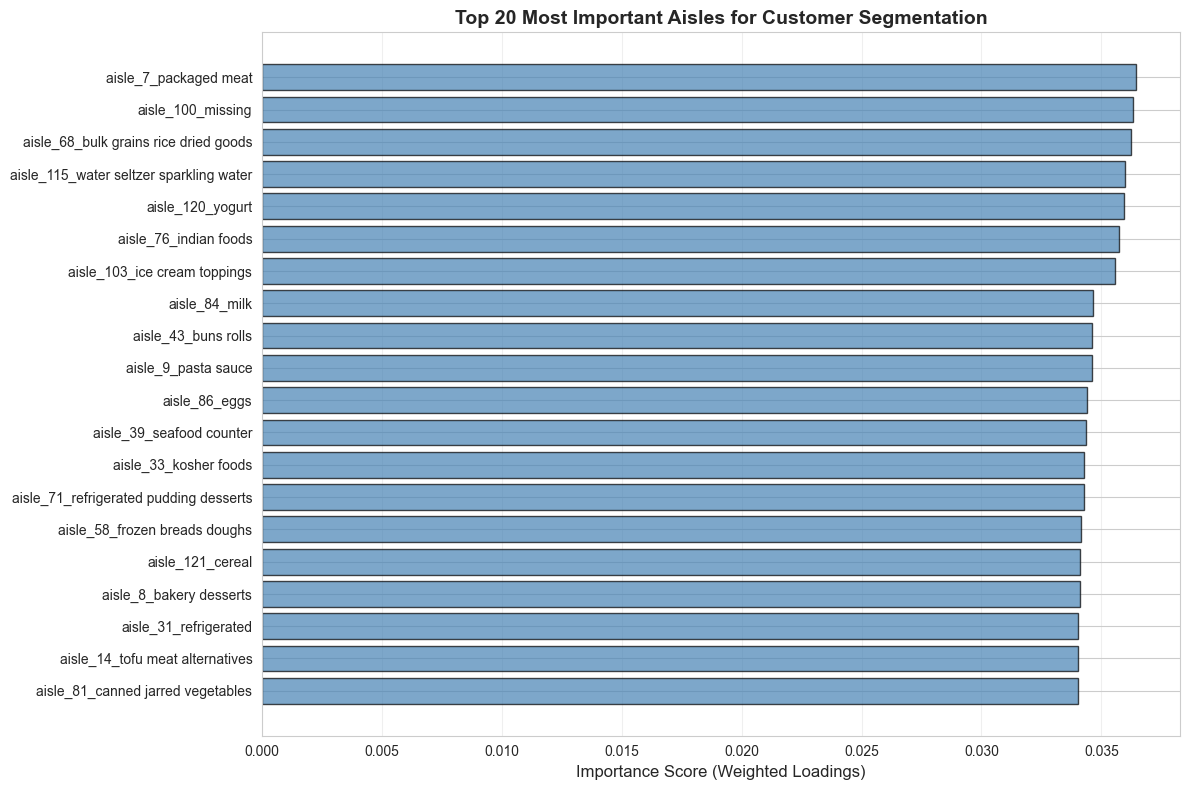


✅ Feature importance plot saved: 03_feature_importance.png


In [15]:
# Create bar chart of top 20 most important aisles
fig, ax = plt.subplots(figsize=(12, 8))

top_20 = feature_importance.head(20)
ax.barh(
    range(len(top_20)),
    top_20['importance_score'],
    color='steelblue',
    edgecolor='black',
    alpha=0.7
)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['aisle'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score (Weighted Loadings)', fontsize=12)
ax.set_title('Top 20 Most Important Aisles for Customer Segmentation',
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / '03_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance plot saved: 03_feature_importance.png")

---

## 7. 2D Visualization of Principal Components

**Why visualize PCs?**
- See data structure in reduced space
- Identify if clusters exist
- Foreshadow clustering challenges
- Publication-quality figure

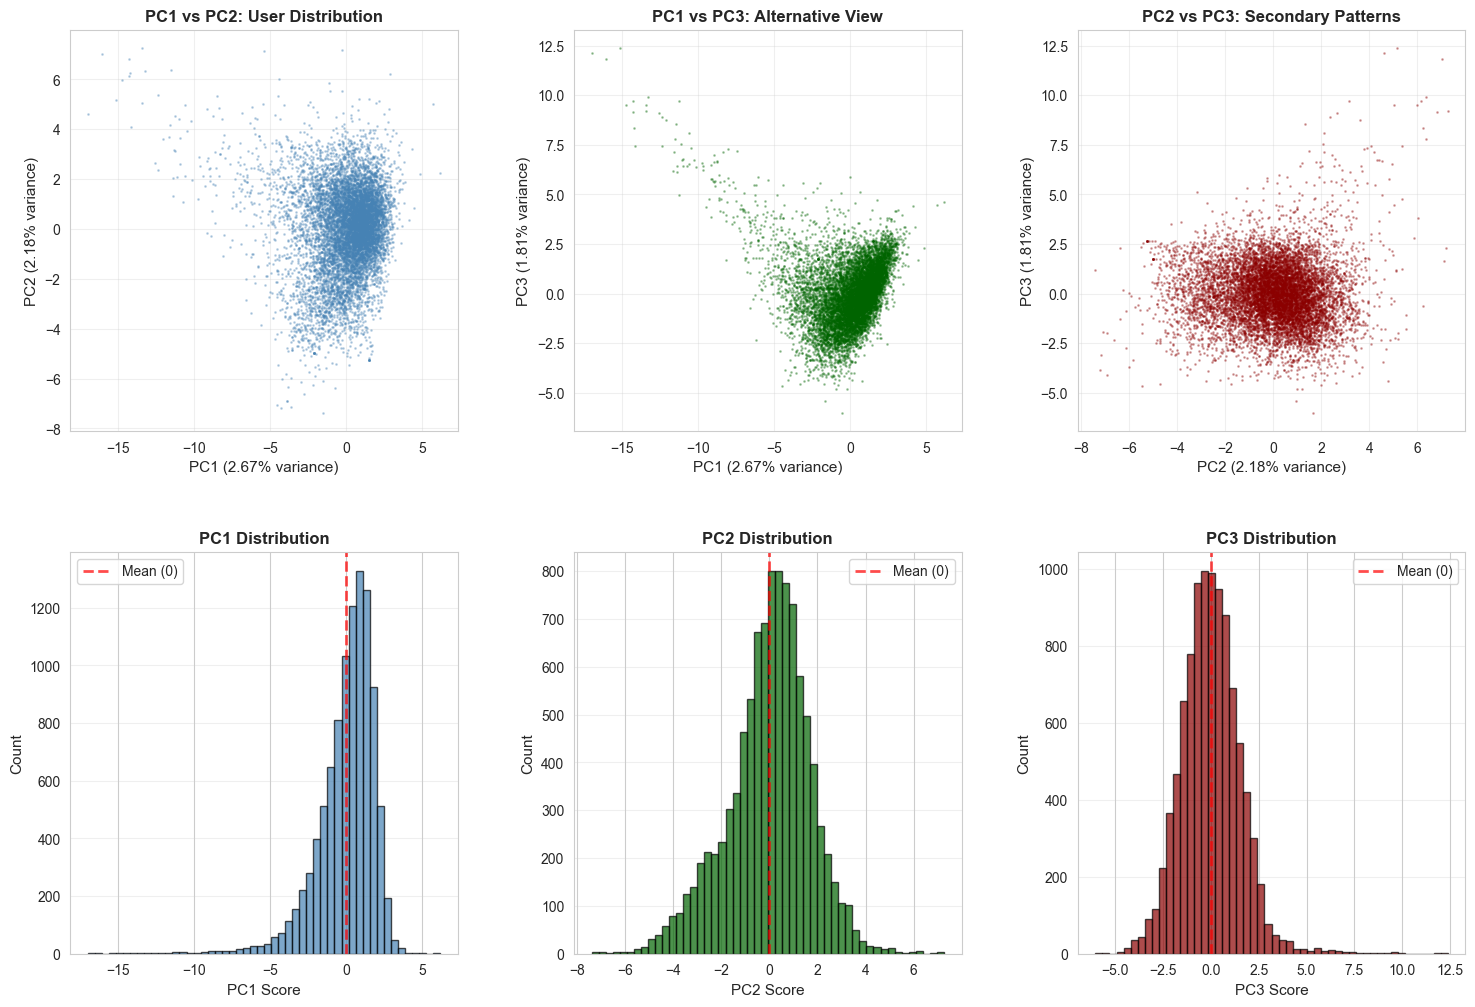


✅ 2D PC visualization saved: 04_pca_2d_visualization.png

💡 Interpretation:
   - Diffuse cloud: No clear discrete clusters visible
   - Normal distributions: Data is homogeneous
   - Foreshadows clustering challenges in Notebook 04
   - Customers exist on continuum, not discrete groups


In [16]:
# Create comprehensive 2D/3D visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Sample data for visualization (too many points = cluttered)
n_sample = min(10000, len(pca_df_final))
sample_idx = np.random.choice(len(pca_df_final), n_sample, replace=False)
pca_sample = pca_df_final.iloc[sample_idx]

# Plot 1: PC1 vs PC2
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(
    pca_sample['PC1'],
    pca_sample['PC2'],
    alpha=0.3,
    s=1,
    c='steelblue'
)
ax1.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=11)
ax1.set_title('PC1 vs PC2: User Distribution', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: PC1 vs PC3
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(
    pca_sample['PC1'],
    pca_sample['PC3'],
    alpha=0.3,
    s=1,
    c='darkgreen'
)
ax2.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=11)
ax2.set_ylabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.2f}% variance)', fontsize=11)
ax2.set_title('PC1 vs PC3: Alternative View', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: PC2 vs PC3
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(
    pca_sample['PC2'],
    pca_sample['PC3'],
    alpha=0.3,
    s=1,
    c='darkred'
)
ax3.set_xlabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=11)
ax3.set_ylabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.2f}% variance)', fontsize=11)
ax3.set_title('PC2 vs PC3: Secondary Patterns', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: PC1 distribution (histogram)
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(pca_sample['PC1'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax4.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean (0)')
ax4.set_xlabel('PC1 Score', fontsize=11)
ax4.set_ylabel('Count', fontsize=11)
ax4.set_title('PC1 Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: PC2 distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(pca_sample['PC2'], bins=50, edgecolor='black', alpha=0.7, color='darkgreen')
ax5.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean (0)')
ax5.set_xlabel('PC2 Score', fontsize=11)
ax5.set_ylabel('Count', fontsize=11)
ax5.set_title('PC2 Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: PC3 distribution
ax6 = fig.add_subplot(gs[1, 2])
ax6.hist(pca_sample['PC3'], bins=50, edgecolor='black', alpha=0.7, color='darkred')
ax6.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean (0)')
ax6.set_xlabel('PC3 Score', fontsize=11)
ax6.set_ylabel('Count', fontsize=11)
ax6.set_title('PC3 Distribution', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.savefig(VIZ_DIR / '04_pca_2d_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ 2D PC visualization saved: 04_pca_2d_visualization.png")

print("\n💡 Interpretation:")
print("   - Diffuse cloud: No clear discrete clusters visible")
print("   - Normal distributions: Data is homogeneous")
print("   - Foreshadows clustering challenges in Notebook 04")
print("   - Customers exist on continuum, not discrete groups")

### 3D Visualization (Interactive)

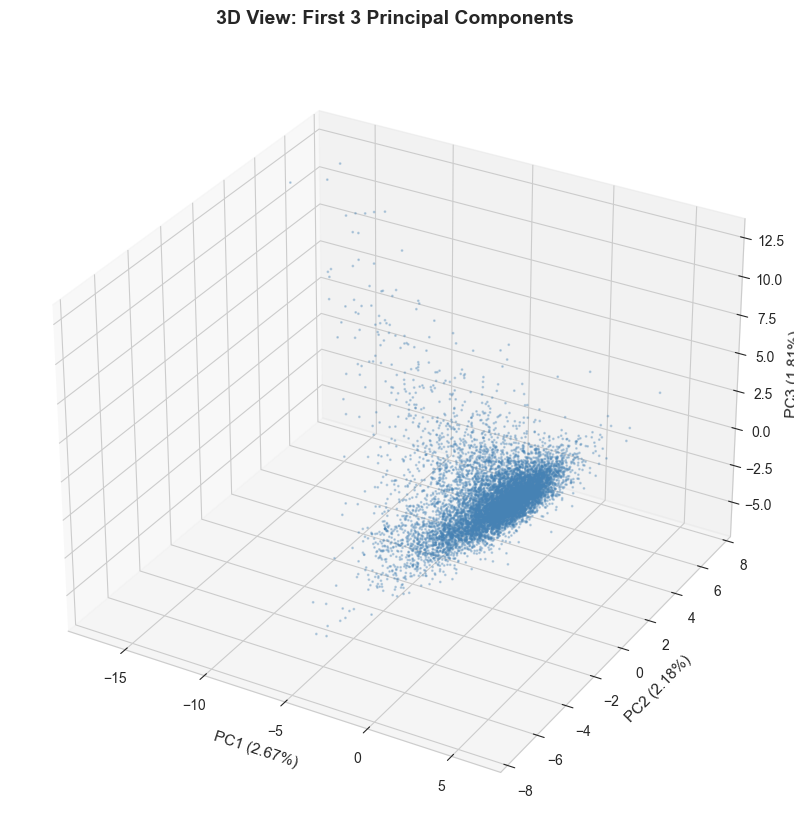


✅ 3D PC visualization saved: 05_pca_3d_visualization.png


In [17]:
# Create 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot sample
ax.scatter(
    pca_sample['PC1'],
    pca_sample['PC2'],
    pca_sample['PC3'],
    alpha=0.3,
    s=1,
    c='steelblue'
)

ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.2f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.2f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.2f}%)', fontsize=11)
ax.set_title('3D View: First 3 Principal Components',
             fontsize=14, fontweight='bold', pad=20)

plt.savefig(VIZ_DIR / '05_pca_3d_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ 3D PC visualization saved: 05_pca_3d_visualization.png")

---

## 8. Combine PCA Components with Behavioral Features

**Final clustering matrix:**
- 50 PCA components (aisle patterns, dimensionality reduced)
- 14 behavioral features (interpretable, preserved as-is)
- Total: 64 features (optimal for clustering)

In [18]:
# Combine PCA components with scaled behavioral features
# Use axis=1 for horizontal concatenation (column-wise)
final_matrix: pd.DataFrame = pd.concat(
    [pca_df_final, scaled_behavioral],
    axis=1
)

print(f"Final clustering matrix:")
print(f"   Shape: {final_matrix.shape}")
print(f"   PCA components: {len(pca_df_final.columns)}")
print(f"   Behavioral features: {len(scaled_behavioral.columns)}")
print(f"   Total features: {len(final_matrix.columns)}")

# Validation
assert len(final_matrix.columns) == N_COMPONENTS + len(behavioral_features), "Feature count mismatch!"
assert len(final_matrix) == len(feature_matrix), "Row count mismatch!"
assert final_matrix.isnull().sum().sum() == 0, "NaN values in final matrix!"

print(f"\n✅ Final matrix validation passed")

# Display sample
print(f"\nSample of final matrix:")
print(final_matrix.head())

print(f"\nColumn breakdown:")
print(f"   Columns 1-50:  PC1-PC50 (aisle patterns)")
print(f"   Columns 51-64: Behavioral features")
print(f"\nBehavioral features included:")
for feat in behavioral_features:
    print(f"   - {feat}")

Final clustering matrix:
   Shape: (182223, 64)
   PCA components: 50
   Behavioral features: 14
   Total features: 64

✅ Final matrix validation passed

Sample of final matrix:
              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
user_id                                                                         
1       -1.966572 -3.438465 -1.294394  0.598293 -1.819745 -2.076370 -0.905213   
2       -0.227792 -1.457350 -1.692038 -1.261772  0.858546 -0.613938 -0.510997   
3        0.741597 -1.590246 -0.164045 -1.461907  0.654644  0.298143 -0.276263   
4       -2.046022 -0.417273 -0.646590  2.274137  3.116213  0.449983 -0.612009   
5        2.018066 -0.511660  1.252119 -0.296485  0.283839  0.424177  0.324427   

              PC8       PC9      PC10  ...  cv_days_between_orders  \
user_id                                ...                           
1       -1.606740 -2.002916  0.191963  ...               -0.484284   
2       -0.592287 -0.567731  0.459473  ...  

---

## 9. Save All Outputs

**Files to save:**
1. Final clustering matrix (for Notebook 04)
2. PCA model (for production deployment)
3. Scaler model (for new data)
4. PC loadings (for interpretation)
5. Feature importance (for business insights)
6. Transformation summary (for documentation)

In [19]:
print("Saving all outputs...\n")

# 1. Save final clustering matrix
final_matrix.to_parquet(OUTPUT_DIR / 'final_clustering_matrix.parquet')
print(f"✅ Saved: final_clustering_matrix.parquet ({final_matrix.shape[0]:,} × {final_matrix.shape[1]})")

# 2. Save PCA model
with open(OUTPUT_DIR / 'pca_model.pkl', 'wb') as f:
    pickle.dump(pca_final, f)
print(f"✅ Saved: pca_model.pkl")

# 3. Save scaler model
with open(OUTPUT_DIR / 'scaler_model.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Saved: scaler_model.pkl")

# 4. PC loadings already saved earlier
print(f"✅ Already saved: pca_loadings.csv")

# 5. Feature importance already saved earlier
print(f"✅ Already saved: feature_importance.csv")

# 6. Save transformation summary
summary = {
    'original_features': len(feature_matrix.columns),
    'aisle_features': len(aisle_features),
    'behavioral_features': len(behavioral_features),
    'pca_components': N_COMPONENTS,
    'final_features': len(final_matrix.columns),
    'variance_explained': float(pca_final.explained_variance_ratio_.sum()),
    'dimensionality_reduction': float(1 - N_COMPONENTS / len(aisle_features)),
    'sklearn_version': sklearn.__version__
}

import json
with open(OUTPUT_DIR / 'transformation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print(f"✅ Saved: transformation_summary.json")

# Print summary
print(f"\n📊 Transformation Summary:")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")

print(f"\n📁 All outputs saved to: {OUTPUT_DIR}")
print(f"📊 All visualizations saved to: {VIZ_DIR}")
print(f"\n✅ Notebook 03 complete!")

Saving all outputs...

✅ Saved: final_clustering_matrix.parquet (182,223 × 64)
✅ Saved: pca_model.pkl
✅ Saved: scaler_model.pkl
✅ Already saved: pca_loadings.csv
✅ Already saved: feature_importance.csv
✅ Saved: transformation_summary.json

📊 Transformation Summary:
   original_features: 149
   aisle_features: 135
   behavioral_features: 14
   pca_components: 50
   final_features: 64
   variance_explained: 0.4668
   dimensionality_reduction: 0.6296
   sklearn_version: 1.6.1

📁 All outputs saved to: data/processed_features
📊 All visualizations saved to: visualizations

✅ Notebook 03 complete!


---

## Summary & Next Steps

### What We Accomplished

✅ **Standardized all features** (mean=0, std=1)  
✅ **Reduced dimensions** (149 → 64 features, 57% reduction)  
✅ **Applied PCA** (135 aisles → 50 components, 46.7% variance)  
✅ **Interpreted PCs** (loadings analysis, top contributing aisles)  
✅ **Visualized structure** (2D/3D plots, diffuse cloud = no discrete clusters)  
✅ **Analyzed importance** (identified key aisles for segmentation)  
✅ **Saved models** (scaler & PCA for production deployment)  

### Key Insights

1. **Data Structure:** Highly diffuse, no single dominant pattern (PC1 only 2.67%)
2. **Clustering Readiness:** 64 features optimal, but diffuse structure suggests challenges
3. **Business Value:** Feature importance identifies key product categories
4. **Production Ready:** Models saved for consistent new user transformation

### Next: Notebook 04 - Clustering Validation

**What to expect:**
- K-Means clustering with k=2 to k=10
- Silhouette score evaluation
- Likely poor results (data is homogeneous)
- Decision to pivot to rule-based segmentation

**Files needed:**
- `final_clustering_matrix.parquet` (created above) ✅

---